In [1]:
import warnings 
warnings.filterwarnings('ignore')

import time
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import model_selection

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.neural_network import MLPClassifier

In [8]:
# load dataset

wd = '/Users/ewenwang/Documents/practice_data/'
file = 'credit_card.csv'
data = pd.read_csv(wd+file)
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [61]:
# prepare models
models = []
# single models
models.append(('LR', LogisticRegression()))
# models.append(('SVC', LinearSVC(loss='hinge')))
models.append(('SDG', SGDClassifier()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('NB', GaussianNB()))
models.append(('CART', DecisionTreeClassifier()))
# ensemble models
models.append(('BAG', BaggingClassifier(DecisionTreeClassifier(), bootstrap=True, oob_score=True, n_jobs=-1)))
models.append(('RF', RandomForestClassifier(n_jobs=-1)))
models.append(('ERT', ExtraTreesClassifier(n_jobs=-1)))
models.append(('ABDT', AdaBoostClassifier(DecisionTreeClassifier())))
models.append(('GBDT', GradientBoostingClassifier()))
# neutral network
models.append(('NN', MLPClassifier()))

In [62]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.2, random_state=0)

target = 'Class'
features = [x for x in data.columns if x not in [target]]

X = train[features]
y = train[target]

In [63]:
# prepare configuration for cross validation test harness
seed = 0

# evaluate each model in turn
results = []
names = []
cost = []
scoring = 'average_precision'
for name, model in models:
    start = time.time()
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    timecost = time.time()-start
    results.append(cv_results)
    names.append(name)
    cost.append(timecost)
    msg = "%s:\t%f (%f)\ttime: %f s" % (name, cv_results.mean(), cv_results.std(), timecost)
    print(msg)

LR:	0.567120 (0.074925)	time: 23.119890 s
SDG:	0.002739 (0.000590)	time: 3.094419 s
LDA:	0.741559 (0.087796)	time: 7.091817 s
KNN:	0.122592 (0.042042)	time: 17.261112 s
NB:	0.168716 (0.038380)	time: 1.827901 s
CART:	0.565083 (0.092809)	time: 131.702637 s
BAG:	0.806165 (0.057373)	time: 473.222638 s
RF:	0.813847 (0.054816)	time: 78.710153 s
ERT:	0.826354 (0.044081)	time: 12.799687 s
ABDT:	0.572088 (0.086832)	time: 140.648764 s
GBDT:	0.575833 (0.186238)	time: 773.477489 s
NN:	0.340732 (0.283334)	time: 48.343320 s


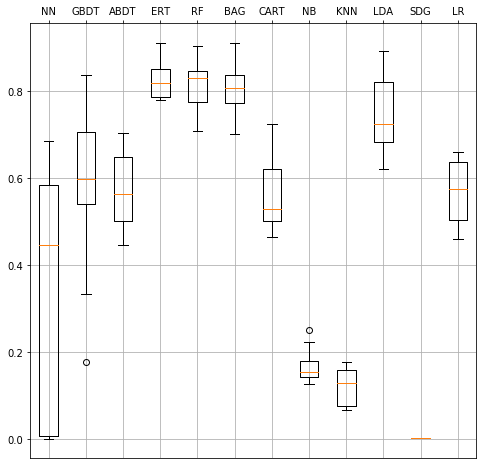

In [64]:
# boxplot algorithm comparison
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
ax.xaxis.tick_top()
# fig.suptitle('Algorithm Comparison')
plt.gca().invert_xaxis()
plt.grid()
plt.show()

In [65]:
means = []
stds = []
for i in results:
    means.append(i.mean())
    stds.append(i.std())

In [66]:
import numpy as np

AmongResults = pd.DataFrame(columns=['model', 'score_mean', 'score_std', 'time'])
AmongResults['model'] = names
AmongResults['score_mean'] = means
AmongResults['score_std'] = stds
AmongResults['time'] = cost
AmongResults['ratio'] = np.power(AmongResults.score_mean, 2)/np.log(AmongResults.time)
AmongResults.sort_values(['ratio'], ascending=False)

,model,score_mean,score_std,time,ratio
2,LDA,0.741559,0.087796,7.091817,0.280718
8,ERT,0.826354,0.044081,12.799687,0.267849
7,RF,0.813847,0.054816,78.710153,0.151714
6,BAG,0.806165,0.057373,473.222638,0.105511
0,LR,0.567120,0.074925,23.119890,0.102406
9,ABDT,0.572088,0.086832,140.648764,0.066168
5,CART,0.565083,0.092809,131.702637,0.065427
10,GBDT,0.575833,0.186238,773.477489,0.049855
4,NB,0.168716,0.038380,1.827901,0.047193
11,NN,0.340732,0.283334,48.343320,0.029935


In [67]:
import seaborn as sns

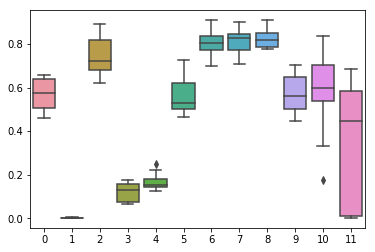

In [68]:
plt.figure()
sns.boxplot(data=results)
plt.show()

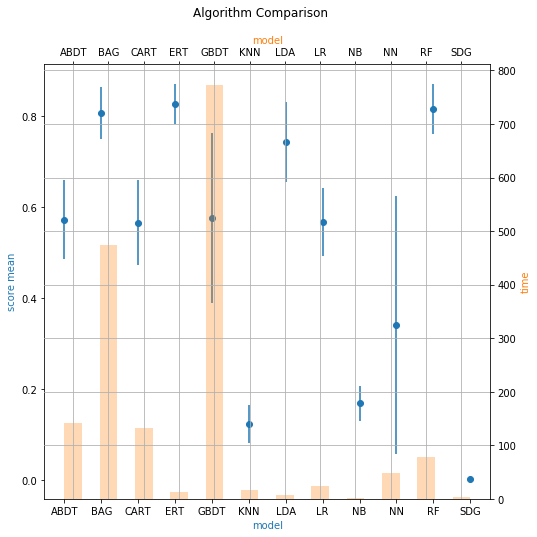

In [69]:
x_values1=AmongResults['model']
y_values1=AmongResults['score_mean']
e_values1=AmongResults['score_std']

x_values2=AmongResults['model']
y_values2=AmongResults['time']

fig=plt.figure(figsize=(8,8))

fig.suptitle('Algorithm Comparison')

ax=fig.add_subplot(111, label="1")
ax2=fig.add_subplot(111, label="2", frame_on=False)

# ax.scatter(x_values1, y_values1, color="C0")
ax.errorbar(x_values1, y_values1, e_values1, color="C0", linestyle='None', marker='o')
ax.set_xlabel("model", color="C0")
ax.set_ylabel("score mean", color="C0")
ax.tick_params(axis="model", colors="C0")
ax.tick_params(axis="score mean", colors="C0")

ax2.bar(x_values2, y_values2, color="C1", alpha=0.3, width=0.5)
ax2.xaxis.tick_top()
ax2.yaxis.tick_right()
ax2.set_xlabel('model', color="C1") 
ax2.set_ylabel('time', color="C1")   
ax2.xaxis.set_label_position('top') 
ax2.yaxis.set_label_position('right') 
ax2.tick_params(axis='model', colors="C1")
ax2.tick_params(axis='time', colors="C1")

plt.grid()
plt.show()